In [25]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import pandas as pd
import sklearn


In [3]:
core_path = "../asteroid_taxonomy/data"
asteroids_df = pd.read_pickle(os.path.join(core_path, "lvl1/asteroids_mergered.pkl"))

In [4]:
# Create a dictionary that maps the Bus Classification with the main group
bus_to_main_dict = {
                    'A': 'Other',
                    'B': 'C',
                    'C': 'C',
                    'Cb': 'C',
                    'Cg': 'C',
                    'Cgh': 'C',
                    'Ch': 'C',
                    'D': 'Other',
                    'K': 'Other',
                    'L': 'Other',
                    'Ld': 'Other',
                    'O': 'Other',
                    'R': 'Other',
                    'S': 'S',
                    'Sa': 'S',
                    'Sk': 'S',
                    'Sl': 'S',
                    'Sq': 'S',
                    'Sr': 'S',
                    'T': 'Other',
                    'V': 'Other',
                    'X': 'X',
                    'Xc': 'X',
                    'Xe': 'X',
                    'Xk': 'X'
                   }

In [5]:
# main group class, data enriching
asteroids_df.loc[:, "Main_Group"] = asteroids_df["Bus_Class"].apply(lambda x: bus_to_main_dict.get(x, "None"))

In [6]:
asteroids_df.head()

,Name,Bus_Class,DesNr,FilePath,SpectrumDF,Main_Group
0,1 Ceres,C,1,asteroid_taxonomy/data/lvl0/smass2/a000001.spf...,Wavelength_in_microm Reflectance_norm550n...,C
1,2 Pallas,B,2,asteroid_taxonomy/data/lvl0/smass2/a000002.spf...,Wavelength_in_microm Reflectance_norm550n...,C
2,3 Juno,Sk,3,asteroid_taxonomy/data/lvl0/smass2/a000003.spf...,Wavelength_in_microm Reflectance_norm550n...,S
3,4 Vesta,V,4,asteroid_taxonomy/data/lvl0/smass2/a000004.spf...,Wavelength_in_microm Reflectance_norm550n...,Other
4,5 Astraea,S,5,asteroid_taxonomy/data/lvl0/smass2/a000005.spf...,Wavelength_in_microm Reflectance_norm550n...,S


In [7]:
asteroids_df.drop(columns=["DesNr", "FilePath"], inplace=True)

In [8]:
pathlib.Path(os.path.join(core_path, "lvl2/")).mkdir(parents=True, exist_ok=True)
asteroids_df.to_pickle(os.path.join(core_path, "lvl2/", "asteroids.pkl"), protocol=4)

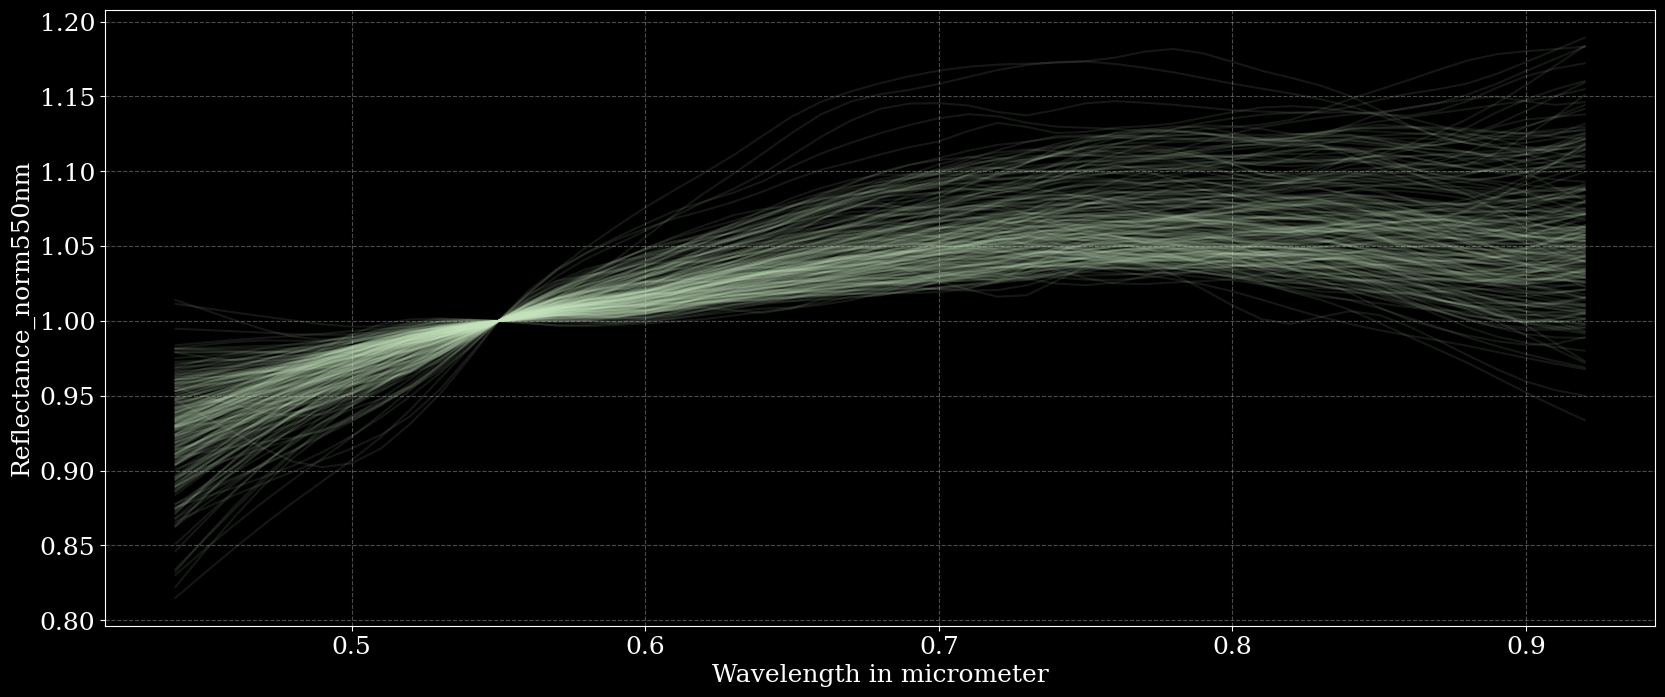

In [9]:
# visaulizing plots
asteroids_filtered_df = asteroids_df.loc[asteroids_df["Main_Group"] == "X"]

plt.style.use("dark_background")
plt.rc('font', family='serif', size=18)

plt.figure(figsize=(20,8))

# used to fine tune the alpha opacity of the graph should be played with to find
# the niche value

nr_of_spec = float(len(asteroids_filtered_df))

for _, row in asteroids_filtered_df.iterrows():
  plt.plot(row["SpectrumDF"]["Wavelength_in_microm"],
          row["SpectrumDF"]["Reflectance_norm550nm"],
          color='#ccebc4',
          alpha=0.1)   # transparencey and opacity of the graph plots

plt.xlabel("Wavelength in micrometer")
plt.ylabel("Reflectance_norm550nm")

plt.grid(linestyle="dashed", alpha = 0.3)

plt.show()

In [10]:
# binary preping of class
asteroids_df.loc[:, "Class"] = asteroids_df["Main_Group"].apply(lambda x: 1 if x == "C" else 0)

In [11]:
asteroids_df["SpectrumDF"][0].head()

,Wavelength_in_microm,Reflectance_norm550nm
0,0.44,0.9281
1,0.45,0.9388
2,0.46,0.9488
3,0.47,0.9572
4,0.48,0.9643


In [14]:
# allocate the spectra to one array and the classes to another one
asteroids_X = np.array([k["Reflectance_norm550nm"].tolist() for k in asteroids_df["SpectrumDF"]])
asteroids_Y = np.array(asteroids_df["Class"].to_list())


In [15]:
# return particular value from each columnn 0 or 1
asteroids_Y

array([1, 1, 0, ..., 0, 0, 0])

Basline Naive score

In [26]:
asteroids_random_y = asteroids_Y.copy()
np.random.shuffle(asteroids_random_y)

f1_score_naive = round(sklearn.metrics.f1_score(asteroids_Y, asteroids_random_y), 3)
print(f"Naive score: {f1_score_naive}")

Naive score: 0.254


In [16]:
# startified shuffle spliting to preserve the ration instead of direct split

from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

for train_index, test_index in sss.split(asteroids_X, asteroids_Y):
    X_train, X_test = asteroids_X[train_index], asteroids_X[test_index]
    Y_train, Y_test = asteroids_Y[train_index], asteroids_Y[test_index]

In [17]:
sum(Y_train)/len(X_train) # ratio has been preserved

np.float64(0.2957089552238806)

In [18]:
# Let's take a look whether the unbalanced ratio has been preserved
print(f"Ratio of positive training classes: {round(sum(Y_train) / len(X_train), 2)}")
print(f"Ratio of positive test classes: {round(sum(Y_test) / len(X_test), 2)}")

Ratio of positive training classes: 0.3
Ratio of positive test classes: 0.3


In [19]:
# computing class weighting
positive_class_weight = int(1.0 / (sum(Y_train) / len(X_train)))
print(f"Positive class weighting metric: {positive_class_weight}")

Positive class weighting metric: 3


In [21]:
# standardscaler and svm basics

# training
from sklearn import svm
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)

# kernel="rbf" radial basis function in infinite poly space, clf - classifier object
wclf = svm.SVC(kernel="rbf", class_weight={1: positive_class_weight}, C=100)

# perform the training
wclf.fit(X_train_scaled, Y_train)

SVC(C=100, class_weight={1: 3})

In [22]:
# scale the testing data now BY "transforming"
X_test_scaled = scaler.transform(X_test)

# ... and perform a prediction
Y_test_pred = wclf.predict(X_test_scaled)

In [23]:
# Metrics
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(Y_test, Y_test_pred)
print(conf_mat)

[[185   4]
 [  1  79]]


In [27]:
# (recall = tp / (tp + fn))
recall_score = round(sklearn.metrics.recall_score(Y_test, Y_test_pred), 3)
print(f"Recall score: {recall_score}")

# Precision: ratio of correctly classified X Class spectra, considering the false positives
# (precision = tp / (tp + fp))
precision_score = round(sklearn.metrics.precision_score(Y_test, Y_test_pred), 3)
print(f"Precision score: {precision_score}")

# A combined score
f1_score = round(sklearn.metrics.f1_score(Y_test, Y_test_pred), 3)
print(f"F1 score: {f1_score}")


Recall score: 0.988
Precision score: 0.952
F1 score: 0.969
